Create database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import engarde.decorators as ed

import toolbox.toolbox as tb

pd.set_option('display.max_colwidth', None)


data = 'Schweizer-Nährwertdatenbank-V6.1.xlsx'
foods = tb.read(data)


my_foods = {
    'avocado, roh': 'avocado',
    'blattsalat (durchschnitt), roh': 'lettuce',
    'blumenkohl, gedämpft (ohne zugabe von salz)': 'cauliflower',
    'champignon, roh': 'mushrooms',    
    'fleisch (durchschnitt exkl. innereien), roh': 'meat',
    'forelle, ganz, gekocht (ohne zusatz von fett und salz)': 'trout',
    'gemüse (durchschnitt), roh': 'vegetables',
    'hart- und halbhartkäse, vollfett (durchschnitt)': 'cheese',
    'hühnerei, ganz, festgekocht': 'eggs',
    'kakaopulver': 'cocoa powder', 
    'kochbutter': 'butter',
    'kokosfett': 'coconut fat',
    'kokosnuss, getrocknet (kokosrapseln, kokosflocken)': 'coconut flakes',
    'mandel': 'almond',
    'olivenöl': 'olive oil',
    'peperoni, rot, roh': 'red pepper',
    'poulet, schenkel, mit haut, gebraten (ohne zusatz von fett und salz)': 'chicken leg',
    'poulet, brust, schnitzel oder geschnetzeltes, gebraten (ohne zusatz von fett und salz)': 'chicken breast',
    'samen, kerne, nüsse (durchschnitt), ungesalzen': 'nuts and seed mix',
    'schwein, hals, steak, gebraten (ohne zusatz von fett und salz)': 'pork steak',
    'spinat, roh': 'spinach', 
    'tofu': 'tofu',
    'vollrahm, uht': 'cream'
}

myfoods = tb.make_myfoods(foods, my_foods).set_index('name')

/Users/fgu/miniconda3/envs/basics/lib/python3.7/site-packages/engarde/checks.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Find items

In [2]:
tb.find_item(foods, 'fore')

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
230,"forelle, ganz, gekocht (ohne zusatz von fett und salz)",fisch/süsswasserfische,pro 100g essbarer Anteil,159,8.8,0.0,0.0,20.1,0.0
231,"forelle, roh",fisch/süsswasserfische,pro 100g essbarer Anteil,127,7.0,0.0,0.0,16.0,0.0


Define meals

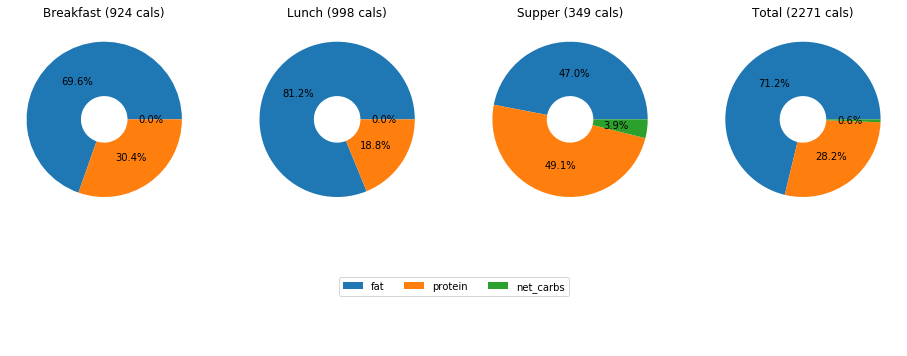

In [12]:
def calc_nutrients(data, meal):
    
    nutrients = ['calories', 'fat', 'protein', 'carbs', 'net_carbs']
    macros = ['fat', 'protein', 'carbs', 'net_carbs']
    portions = list(meal.values())
    
    data = (data.loc[data.index.isin(meal), nutrients]
            .reindex(meal)
            .multiply(portions, axis=0))
    
    grams = data[macros].copy().T.sum(1)
#     grams['total'] = grams.sum()
    grams[grams < 0] = 0
    
    cals = pd.Series(dtype='float')
    cals['fat'] = grams.fat * 9
    cals['protein'] = grams.protein * 4
    cals['carbs'] = grams.carbs * 4
    cals['net_carbs'] = grams.net_carbs * 4
#     cals['total'] = data['calories'].sum()
    cals[cals < 0] = 0
    
    nuts = pd.concat([grams, cals], axis=1)
    nuts = nuts.reindex(['fat', 'protein', 'carbs', 'net_carbs'])
    nuts[nuts < 0] = 0
    nuts.columns = ['grams', 'cals']
    
    return nuts


def make_nuts_dict(meals):
    meal_nuts = {meal: calc_nutrients(myfoods, meals[meal]) for meal in meals}
    meal_nuts['total'] = sum([meal_nuts[meal] for meal in meal_nuts])
    return meal_nuts


def make_cals_dashboard(meals):

    rows = ['fat', 'protein', 'net_carbs']
    
    def make_doughnut(meal_data, axis, meal_name):
        nuts = meal_data.loc[rows]
        total_cals = nuts['cals'].sum()
        
        ax[axis].pie(nuts.cals,
                     autopct='%.1f%%',
                     wedgeprops=dict(width=0.7))
        ax[axis].set_title(f"{meal_name.capitalize()} ({total_cals:.0f} cals)")
        
    fig, ax = plt.subplots(1, len(meals), figsize=(16, 8))

    for meal_num, meal_name in enumerate(meals):
        make_doughnut(meals[meal_name], meal_num, meal_name)

    fig.legend(rows, 
               loc='lower center', 
               borderaxespad=6, ncol=3);
    
meals = {
    
    'breakfast': {
        'cauliflower': 1,
        'cheese': 1.5,
        'eggs': 2,
        'spinach': 0.5,
    },
    
    'lunch': {
        'avocado': 0.8,
        'cauliflower': 1,        
        'cheese': .5,
        'lettuce': 1.5,
        'nuts and seed mix': .5,        
        'olive oil': .3,
        'tofu': 2,
    },

    'supper': {
        'avocado': 0,
        'butter': 0,
        'trout': 2,
        'vegetables': 2,
    }
}

meal_nuts = make_nuts_dict(meals)

make_cals_dashboard(meal_nuts)

In [13]:
meal_nuts['breakfast']

,grams,cals
fat,71.45,643.05
protein,70.15,280.60
carbs,3.40,13.60
net_carbs,0.00,0.00


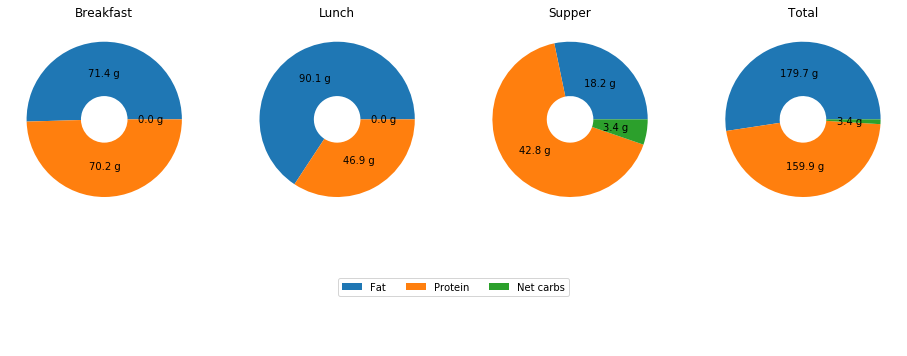

In [26]:
def make_grams_dashboard(meals):
    
    rows = ['fat', 'protein', 'net_carbs']

    def make_doughnut(meal_data, axis, meal_name):
        nuts = meal_data.loc[rows]
        
        def wedge_labs(autopct, nuts):
            return f'{autopct / 100 * nuts.grams.sum():.1f} g'
        
        ax[axis].pie(nuts.grams,
                     autopct=lambda autopct: wedge_labs(autopct, nuts),
                     wedgeprops=dict(width=0.7))
        ax[axis].set_title(f"{meal_name.capitalize()}")
        
    fig, ax = plt.subplots(1, len(meals), figsize=(16, 8))

    for meal_num, meal_name in enumerate(meals):
        make_doughnut(meals[meal_name], meal_num, meal_name)

    fig.legend(['Fat', 'Protein', 'Net carbs'], 
               loc='lower center', 
               borderaxespad=6, ncol=3);
    

make_grams_dashboard(meal_nuts)